# Week 8: Instance-Based Learning - KNN & SVM Regression

---

## 🎯 What You'll Learn This Week

Instance-based methods make predictions by comparing new data points to similar historical examples. They're like asking: "What happened the last few times the market looked like this?"

**Key Concepts:**
- K-Nearest Neighbors (KNN) for regression and classification
- Distance metrics (Euclidean, Manhattan, Mahalanobis)
- Support Vector Regression (SVR)
- Finance applications: regime matching, pattern recognition

**Why This Matters:**
In trading, history often rhymes. Instance-based methods find similar historical periods and use those outcomes to inform predictions.

---

## Table of Contents
1. K-Nearest Neighbors (KNN)
2. Distance Metrics
3. Support Vector Regression (SVR)
4. Financial Applications

---

In [1]:
# Standard imports and data loading
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Standard 5 equities for analysis
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'SPY']

# Fetch 5 years of data
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading market data...")
data = yf.download(TICKERS, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} days of data for {len(TICKERS)} tickers")
print(f"📅 Date range: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
print(prices.tail())

📥 Downloading market data...
✅ Loaded 1255 days of data for 5 tickers
📅 Date range: 2021-01-25 to 2026-01-22
Ticker            AAPL       GOOGL         JPM        MSFT         SPY
Date                                                                  
2026-01-15  258.209991  332.779999  309.260010  456.660004  692.239990
2026-01-16  255.529999  330.000000  312.470001  459.859985  691.659973
2026-01-20  246.699997  322.000000  302.739990  454.519989  677.580017
2026-01-21  247.649994  328.380005  302.040009  444.109985  685.400024
2026-01-22  250.529999  331.309906  305.130005  451.790009  690.505005


---

## 1. K-Nearest Neighbors (KNN)

### 🤔 Simple Explanation

KNN is like asking your neighbors for advice. When you want to predict something:
1. Find the k most similar historical examples
2. Average their outcomes (regression) or vote (classification)

**The Algorithm:**
$$\hat{y} = \frac{1}{k}\sum_{i \in N_k(x)} y_i$$

Where $N_k(x)$ is the set of k nearest neighbors.

### Key Trade-off: Choosing k
- **Small k (e.g., 1-3)**: Very responsive, but sensitive to noise
- **Large k (e.g., 20-50)**: Smoother predictions, but may miss local patterns

In [2]:
# Create features for KNN
# We'll predict next-day returns using recent market indicators

def create_knn_features(prices_df, returns_df, lookback=20):
    """Create features for KNN-based prediction."""
    features = pd.DataFrame(index=returns_df.index)
    
    # For each ticker, create features based on market-wide indicators
    spy_returns = returns_df['SPY']
    
    # Recent return patterns
    features['ret_1d'] = spy_returns
    features['ret_5d'] = spy_returns.rolling(5).sum()
    features['ret_20d'] = spy_returns.rolling(20).sum()
    
    # Volatility
    features['vol_5d'] = spy_returns.rolling(5).std()
    features['vol_20d'] = spy_returns.rolling(20).std()
    
    # Volume proxy (using price range)
    spy_prices = prices_df['SPY']
    features['range'] = (spy_prices.rolling(5).max() - spy_prices.rolling(5).min()) / spy_prices
    
    # Moving average ratio
    features['ma_ratio'] = spy_prices.rolling(5).mean() / spy_prices.rolling(20).mean()
    
    return features.dropna()

# Create features
features = create_knn_features(prices, returns)
target = returns['SPY'].shift(-1)  # Next-day return

# Align data
common_idx = features.index.intersection(target.dropna().index)
X = features.loc[common_idx]
y = target.loc[common_idx]

print(f"Features shape: {X.shape}")
print(f"Feature names: {list(X.columns)}")
print(f"\nFeature statistics:")
print(X.describe().round(4))

Features shape: (1234, 7)
Feature names: ['ret_1d', 'ret_5d', 'ret_20d', 'vol_5d', 'vol_20d', 'range', 'ma_ratio']

Feature statistics:
          ret_1d     ret_5d    ret_20d     vol_5d    vol_20d      range  \
count  1234.0000  1234.0000  1234.0000  1234.0000  1234.0000  1234.0000   
mean      0.0006     0.0029     0.0117     0.0092     0.0097     0.0213   
std       0.0108     0.0226     0.0411     0.0060     0.0048     0.0145   
min      -0.0585    -0.1189    -0.1249     0.0007     0.0034     0.0018   
25%      -0.0045    -0.0082    -0.0099     0.0054     0.0065     0.0117   
50%       0.0007     0.0046     0.0190     0.0080     0.0086     0.0178   
75%       0.0063     0.0157     0.0380     0.0115     0.0115     0.0269   
max       0.1050     0.0859     0.1478     0.0653     0.0344     0.1370   

        ma_ratio  
count  1234.0000  
mean      1.0040  
std       0.0182  
min       0.9362  
25%       0.9943  
50%       1.0075  
75%       1.0154  
max       1.0495  


KNN: Effect of k (number of neighbors)
k= 1: Train R² = 1.0000, Test R² = -0.6987
k= 3: Train R² = 0.3091, Test R² = -0.1552
k= 5: Train R² = 0.1828, Test R² = -0.1704
k=10: Train R² = 0.0961, Test R² = 0.0033
k=20: Train R² = 0.0486, Test R² = 0.0212
k=50: Train R² = 0.0169, Test R² = 0.0136


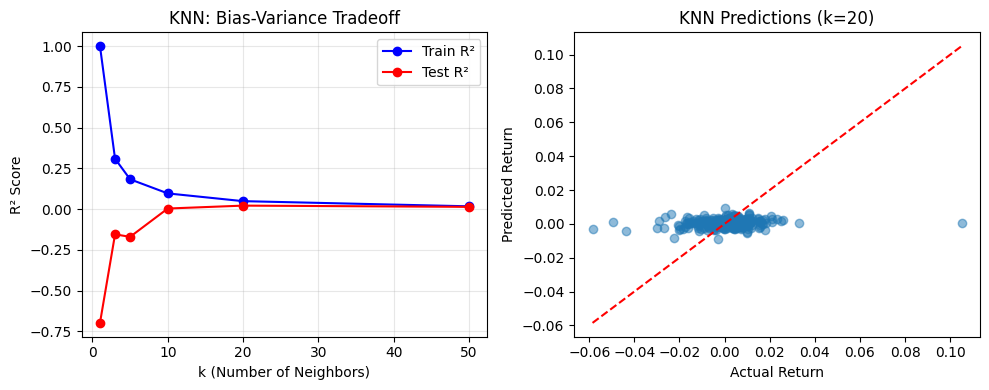


✅ Best k = 20 with Test R² = 0.0212


In [3]:
# Scale features (CRITICAL for KNN!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data (time-series aware - no shuffle!)
split_idx = int(len(X) * 0.7)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("KNN: Effect of k (number of neighbors)")
print("="*60)

# Test different k values
k_values = [1, 3, 5, 10, 20, 50]
results = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    
    results.append({'k': k, 'train_r2': train_score, 'test_r2': test_score})
    print(f"k={k:2d}: Train R² = {train_score:.4f}, Test R² = {test_score:.4f}")

results_df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(results_df['k'], results_df['train_r2'], 'b-o', label='Train R²')
plt.plot(results_df['k'], results_df['test_r2'], 'r-o', label='Test R²')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('R² Score')
plt.title('KNN: Bias-Variance Tradeoff')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Best k model predictions
best_k = results_df.loc[results_df['test_r2'].idxmax(), 'k']
knn_best = KNeighborsRegressor(n_neighbors=int(best_k))
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Return')
plt.ylabel('Predicted Return')
plt.title(f'KNN Predictions (k={int(best_k)})')
plt.tight_layout()
plt.show()

print(f"\n✅ Best k = {int(best_k)} with Test R² = {results_df['test_r2'].max():.4f}")

---

## 2. Distance Metrics

### 🤔 How Do We Measure "Similar"?

Different distance metrics capture different notions of similarity:

| Metric | Formula | Best For |
|--------|---------|----------|
| Euclidean (L2) | $\sqrt{\sum_i (x_i - y_i)^2}$ | Standard, continuous |
| Manhattan (L1) | $\sum_i \|x_i - y_i\|$ | Robust to outliers |
| Chebyshev | $\max_i \|x_i - y_i\|$ | Max deviation matters |

**Key Insight:** The "best" metric depends on your data and what "similar" means in your context.

Distance Metric Comparison (k=10)
euclidean   : Train R² = 0.0961, Test R² = 0.0033
manhattan   : Train R² = 0.0858, Test R² = -0.0251
chebyshev   : Train R² = 0.0776, Test R² = -0.0233


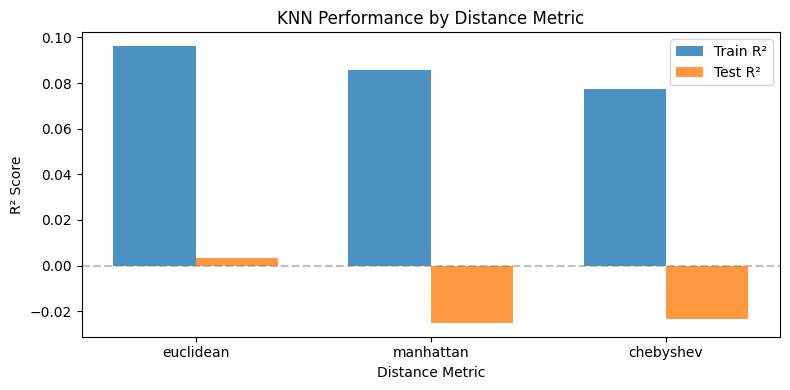

In [4]:
# Compare different distance metrics
metrics = ['euclidean', 'manhattan', 'chebyshev']

print("Distance Metric Comparison (k=10)")
print("="*60)

metric_results = []
for metric in metrics:
    knn = KNeighborsRegressor(n_neighbors=10, metric=metric)
    knn.fit(X_train, y_train)
    
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    
    metric_results.append({
        'metric': metric,
        'train_r2': train_score,
        'test_r2': test_score
    })
    print(f"{metric:12}: Train R² = {train_score:.4f}, Test R² = {test_score:.4f}")

# Visualize distance metric comparison
metric_df = pd.DataFrame(metric_results)
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(metrics))
width = 0.35
ax.bar(x - width/2, metric_df['train_r2'], width, label='Train R²', alpha=0.8)
ax.bar(x + width/2, metric_df['test_r2'], width, label='Test R²', alpha=0.8)
ax.set_xlabel('Distance Metric')
ax.set_ylabel('R² Score')
ax.set_title('KNN Performance by Distance Metric')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

---

## 3. Support Vector Regression (SVR)

### 🤔 Simple Explanation

SVR creates a "tube" around predictions. Points inside the tube have zero error. Only points outside contribute to the loss.

**ε-Insensitive Loss:**
$$L_\epsilon(y, f(x)) = \max(0, |y - f(x)| - \epsilon)$$

### Key Hyperparameters:
- **C**: Penalty for points outside tube (higher = stricter)
- **epsilon (ε)**: Width of the tube
- **kernel**: RBF (non-linear) vs Linear

Support Vector Regression (SVR)
linear   kernel: Train R² = 0.0009, Test R² = -0.0062
rbf      kernel: Train R² = 0.6262, Test R² = -0.4213
poly     kernel: Train R² = 0.1319, Test R² = -75.1803


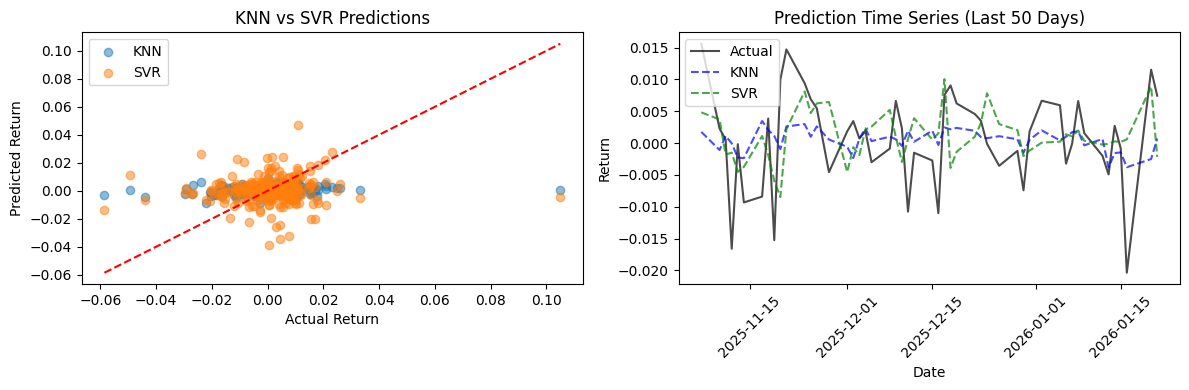

In [5]:
# SVR Comparison
print("Support Vector Regression (SVR)")
print("="*60)

# Test different kernels
kernels = ['linear', 'rbf', 'poly']
svr_results = []

for kernel in kernels:
    svr = SVR(kernel=kernel, C=1.0, epsilon=0.001)
    svr.fit(X_train, y_train)
    
    train_score = svr.score(X_train, y_train)
    test_score = svr.score(X_test, y_test)
    
    svr_results.append({
        'kernel': kernel,
        'train_r2': train_score,
        'test_r2': test_score
    })
    print(f"{kernel:8} kernel: Train R² = {train_score:.4f}, Test R² = {test_score:.4f}")

# Best SVR model
best_svr = SVR(kernel='rbf', C=1.0, epsilon=0.001)
best_svr.fit(X_train, y_train)
y_pred_svr = best_svr.predict(X_test)

# Compare KNN vs SVR
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(y_test, y_pred, alpha=0.5, label='KNN')
axes[0].scatter(y_test, y_pred_svr, alpha=0.5, label='SVR')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel('Actual Return')
axes[0].set_ylabel('Predicted Return')
axes[0].set_title('KNN vs SVR Predictions')
axes[0].legend()

# Prediction comparison over time
test_dates = y.iloc[split_idx:].index
axes[1].plot(test_dates[-50:], y_test.values[-50:], 'k-', label='Actual', alpha=0.7)
axes[1].plot(test_dates[-50:], y_pred[-50:], 'b--', label='KNN', alpha=0.7)
axes[1].plot(test_dates[-50:], y_pred_svr[-50:], 'g--', label='SVR', alpha=0.7)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Return')
axes[1].set_title('Prediction Time Series (Last 50 Days)')
axes[1].legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

## 4. Financial Application: Market Regime Matching

### 🤔 The Idea

Use KNN to find similar historical market conditions and see what happened next.

**Features:**
- Volatility level
- Recent momentum
- MA ratio (trend indicator)

This is like a quantitative way of saying: "What happened the last 10 times VIX was this high and momentum was this low?"

Market Regime Matching - Multi-Asset Analysis
AAPL: Train R² = 0.0315, Test R² = -0.0441
MSFT: Train R² = 0.0464, Test R² = -0.0331
GOOGL: Train R² = 0.0499, Test R² = -0.0293
JPM: Train R² = 0.0477, Test R² = 0.0062
SPY: Train R² = 0.0376, Test R² = 0.0006


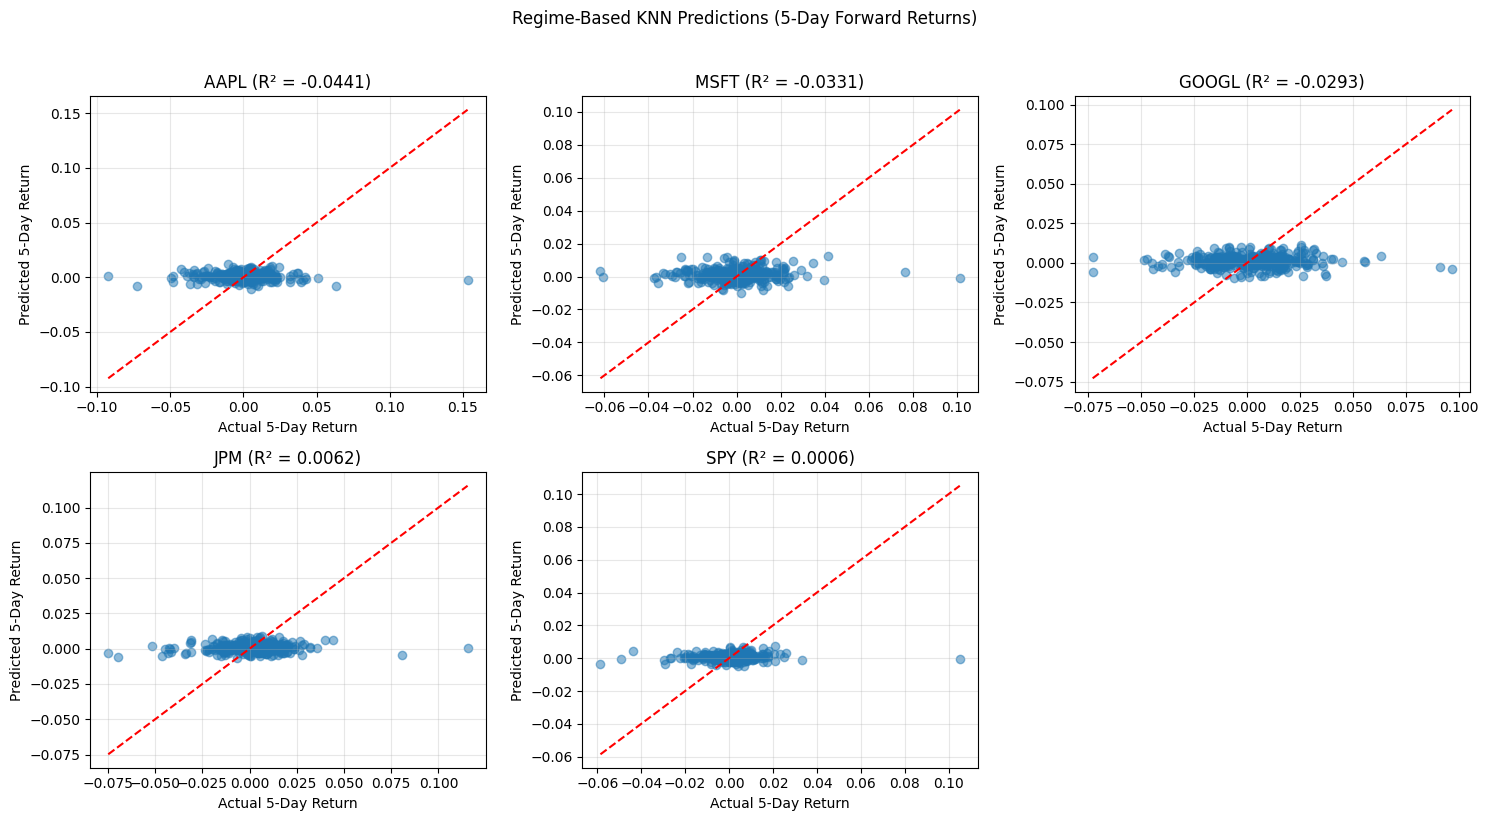

In [6]:
# Market Regime Matching for all tickers
print("Market Regime Matching - Multi-Asset Analysis")
print("="*60)

# Create regime features using market-wide data
regime_features = pd.DataFrame(index=returns.index)
regime_features['vol_20d'] = returns['SPY'].rolling(20).std() * np.sqrt(252)  # Annualized vol
regime_features['momentum_20d'] = prices['SPY'].pct_change(20)
regime_features['ma_ratio'] = prices['SPY'].rolling(5).mean() / prices['SPY'].rolling(20).mean()
regime_features = regime_features.dropna()

# Scale features
scaler_regime = StandardScaler()
X_regime = scaler_regime.fit_transform(regime_features)

# For each ticker, use KNN to predict returns based on regime
regime_results = {}

for ticker in TICKERS:
    ticker_returns = returns[ticker].shift(-5)  # 5-day forward return
    common_idx = regime_features.index.intersection(ticker_returns.dropna().index)
    
    y_regime = ticker_returns.loc[common_idx]
    X_regime_aligned = scaler_regime.transform(regime_features.loc[common_idx])
    
    # Time-series split
    split = int(len(X_regime_aligned) * 0.7)
    X_tr, X_te = X_regime_aligned[:split], X_regime_aligned[split:]
    y_tr, y_te = y_regime.iloc[:split], y_regime.iloc[split:]
    
    # KNN model
    knn_regime = KNeighborsRegressor(n_neighbors=20)
    knn_regime.fit(X_tr, y_tr)
    
    train_r2 = knn_regime.score(X_tr, y_tr)
    test_r2 = knn_regime.score(X_te, y_te)
    
    regime_results[ticker] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'predictions': knn_regime.predict(X_te),
        'actual': y_te.values
    }
    
    print(f"{ticker}: Train R² = {train_r2:.4f}, Test R² = {test_r2:.4f}")

# Visualize regime-based predictions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, ticker in enumerate(TICKERS):
    ax = axes[i]
    ax.scatter(regime_results[ticker]['actual'], regime_results[ticker]['predictions'], alpha=0.5)
    ax.plot([regime_results[ticker]['actual'].min(), regime_results[ticker]['actual'].max()],
            [regime_results[ticker]['actual'].min(), regime_results[ticker]['actual'].max()], 'r--')
    ax.set_xlabel('Actual 5-Day Return')
    ax.set_ylabel('Predicted 5-Day Return')
    ax.set_title(f'{ticker} (R² = {regime_results[ticker]["test_r2"]:.4f})')
    ax.grid(True, alpha=0.3)

axes[-1].axis('off')  # Hide extra subplot
plt.suptitle('Regime-Based KNN Predictions (5-Day Forward Returns)', y=1.02)
plt.tight_layout()
plt.show()

---

## 📊 Summary & Key Takeaways

### What We Learned:

1. **KNN Basics**: Find k similar historical examples, average their outcomes
2. **k Selection**: Small k = high variance, large k = high bias
3. **Distance Metrics**: Euclidean is default, but others may work better
4. **SVR**: Creates ε-tube, more robust to outliers
5. **Scaling is CRITICAL**: Always standardize features!

### Trading Applications:

| Method | Use Case |
|--------|----------|
| KNN Regression | Predict returns from similar regimes |
| KNN Classification | Classify market state (bull/bear) |
| SVR | Robust prediction with outlier handling |

### Key Formula Summary:

$$\text{KNN Prediction: } \hat{y} = \frac{1}{k}\sum_{i \in N_k(x)} y_i$$

$$\text{SVR Loss: } L_\epsilon = \max(0, |y - f(x)| - \epsilon)$$

---

## 🔑 Interview Questions

1. **When would you use KNN over a parametric model?**
2. **How does k affect bias-variance tradeoff?**
3. **What preprocessing is essential for KNN?**
4. **Compare KNN vs SVR for financial prediction.**

---